## Naratip Chakansin
## 03-18-2024

# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours).

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfall in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [7]:
!nvidia-smi

Mon Mar 18 21:05:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P8              15W / 170W |    340MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
# For summarizing and visualizing models
!pip install torchinfo
!pip install torchviz

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [9]:
!pip install wandb

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [10]:
!wandb login

wandb: Currently logged in as: naratip-18257. Use `wandb login --relogin` to force relogin


In [11]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

torch.__version__ # 1.10.0+cu111

'2.2.1+cu121'

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [12]:
def read_data(months, data_dir='./nowcastingHWdataset/dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)

        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [13]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features**
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [14]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


In [15]:
x_train[0, 0, 0:5, 0:5, 0]

array([[227.82625, 227.39946, 227.39946, 227.82625, 227.82625],
       [228.24669, 228.24669, 228.24669, 228.24669, 228.03725],
       [228.45459, 228.45459, 228.24669, 228.24669, 228.24669],
       [228.66098, 228.45459, 228.45459, 228.45459, 228.24669],
       [229.47194, 229.27135, 229.27135, 229.27135, 229.27135]],
      dtype=float32)

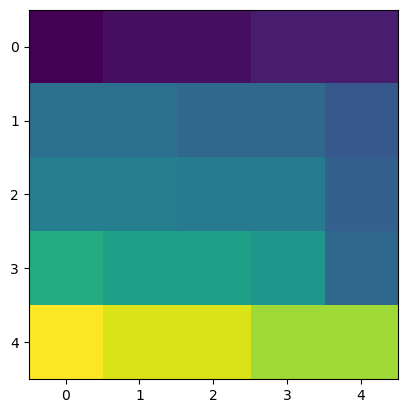

In [16]:
plt.imshow(x_train[0, 0, 0:5, 0:5, 1])

In [17]:
y_train[:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 6., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:** 
- This function is trying to treat each datapoint as an feature for neural-network
- consider x_train_ff, x_val_ff, x_test_ff is come from treat dim 0 & dim 1 as inputs and dim 2, dim 3, dim 4 as feature
- consider y_train_ff, y_val_ff, y_test_ff is come from treat dim 0 & size of dim 1 as inputs so there is one label for each inputs

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [18]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [19]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [20]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [22]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:** I think it is because we are trying to predict amount of rainfall so this is regression problem and using MSE is suitable

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [24]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:** It is relu because it is none linear function and we want amount of rainfall greater or equal zero. In my opinion relu is a good one. 

In [202]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

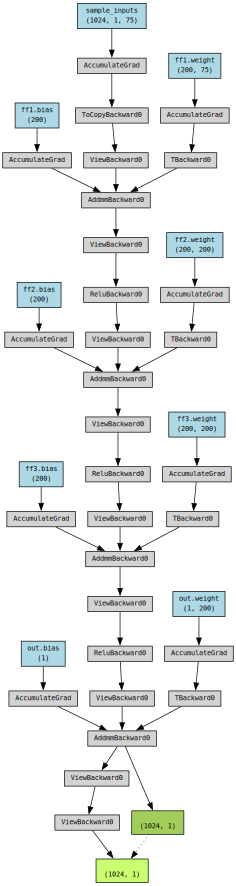

In [203]:
from torchviz import make_dot
# Visualize model with torchviz
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [204]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:** Because inputs is (1024, 75) so hidden layers is (75, 200) = 75*200 = 15,000 plus bias for output layer 200 so number of param is 15,200

# Training

In [205]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })
wandb.unwatch()
wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9370
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6607
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9237
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6629
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9228
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6593
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9226
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6623
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9233
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6608
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9235
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6610
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9233
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6610
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9239
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6614
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9235
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6612
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9233
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6613


lr,██████▂▂▂▁
train_loss,█▂▁▁▁▁▁▂▁▁
val_loss,▄█▁▇▄▄▄▅▅▅
lr,0.0004
train_loss,1.92328
val_loss,1.66131


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

In [206]:
import seaborn as sns

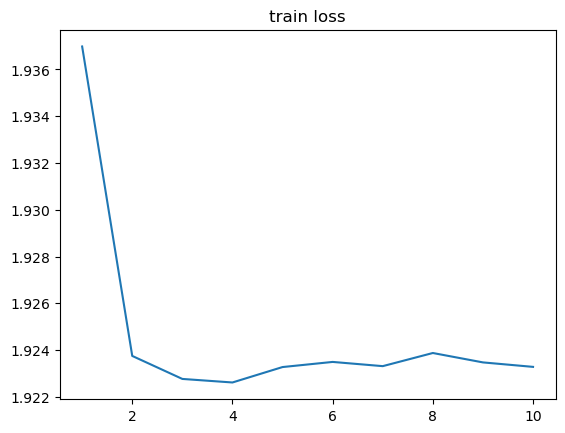

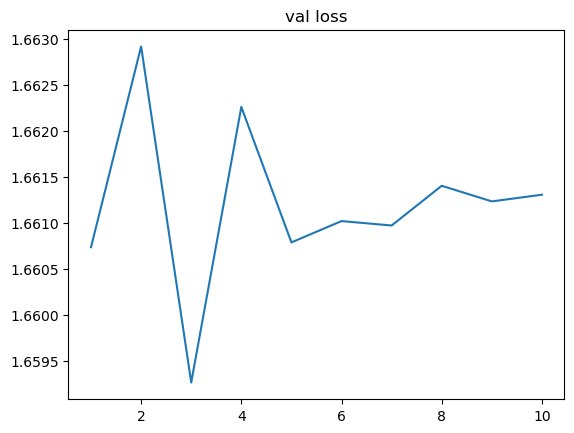

In [338]:
sns.lineplot(y= train_losses, x = [i for i in range(1,11)]).set_title('train loss')
plt.show()
sns.lineplot(y= val_losses, x = [i for i in range(1,11)]).set_title('val loss')
plt.show()

### TODO#6

When does the model start to overfit?

**Ans:** after epoch 5

### TODO#7

Plot the learning rate as a function of the epochs.

Text(0.5, 1.0, 'learning rate')

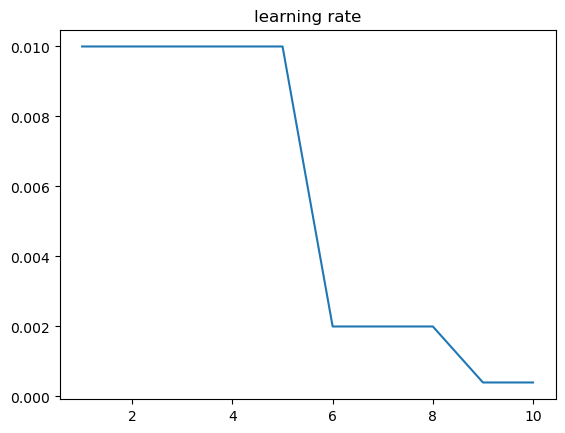

In [44]:
sns.lineplot(y = learning_rates, x = [i for i in range(1,11)]).set_title('learning rate')

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:** I think it is because of increasing of validation loss

# Load Model

Use the code snippet below to load the model you just trained

In [45]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 4 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [110]:
np.sqrt(0.1)

0.31622776601683794

In [158]:
# Implement scheduler here
from torch.optim.lr_scheduler import LinearLR, MultiStepLR, ConstantLR, MultiplicativeLR, StepLR
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer
        self.scheduler1 = LinearLR(self.optimizer, start_factor=0.01, end_factor=0.1, total_iters=3)
        self.scheduler2 = LinearLR(self.optimizer, start_factor=1, end_factor=0.5, total_iters=3)
        self.scheduler3 = MultiplicativeLR(self.optimizer, lr_lambda= lambda epoch: 2)
        self.scheduler4 = LinearLR(self.optimizer, start_factor=1, end_factor=0.1, total_iters=2)

    def step(self, epoch):
        # Changes the learning rate here
        if 0 <= epoch < 3 :
            self.scheduler1.step()
        elif 3 <= epoch < 6:
            self.scheduler2.step()
        elif 6 <= epoch < 7:
            self.scheduler3.step()
        elif 7 <= epoch < 9:
            self.scheduler4.step()

In [159]:
config2 = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}
model_ff2 = FeedForwardNN(hidden_size=config2['hidden_size'])
model_ff2 = model_ff2.to(device)
optimizer2 = torch.optim.Adam(model_ff2.parameters(), lr=config2['lr'])
my_scheduler = MyScheduler(optimizer2)

In [160]:
# Now train with your scheduler
train_losses_2 = []
val_losses_2 = []
learning_rates_2 = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-with-my-scheduler',
    config=config2,
)

# Log parameters and gradients
wandb.watch(model_ff2, log='all')

for epoch in range(config2['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss_2 = []
    current_lr = optimizer2.param_groups[0]['lr']
    learning_rates_2.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff2.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer2.zero_grad()

        # Predict
        y_pred = model_ff2(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer2.step()

        # Log stuff
        train_loss_2.append(loss)

    avg_train_loss = torch.stack(train_loss_2).mean().item()
    train_losses_2.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff2.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss_2 = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff2(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss_2.append(loss)

        avg_val_loss = torch.stack(val_loss_2).mean().item()
        val_losses_2.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        my_scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_2[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff2.state_dict(),
                'optimizer': optimizer2.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })
wandb.unwatch()
wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9203
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6565
Saving new best model..
Training epoch 2...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9186
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6559
Saving new best model..
Training epoch 3...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9185
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6570
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9184
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6562
Training epoch 5...
Current LR: 0.0008333333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9182
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6567
Training epoch 6...
Current LR: 0.0006666666666666668


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9178
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6569
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9179
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6570
Training epoch 8...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9185
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6588
Training epoch 9...
Current LR: 0.00055


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9178
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6554
Saving new best model..
Training epoch 10...
Current LR: 0.00010000000000000005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9175
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6555


lr,▁▃▆█▇▅▄█▄▁
train_loss,█▄▄▃▃▂▂▃▂▁
val_loss,▃▂▄▃▄▄▄█▁▁
lr,0.0001
train_loss,1.91747
val_loss,1.65545


Finished Training


In [161]:
print(learning_rates_2)
print(val_losses_2)
print(train_losses_2)

[0.0001, 0.0004, 0.0007, 0.001, 0.0008333333333333334, 0.0006666666666666668, 0.0005, 0.001, 0.00055, 0.00010000000000000005]
[1.6564747095108032, 1.655909538269043, 1.6569640636444092, 1.656205654144287, 1.6567081212997437, 1.6568599939346313, 1.657004714012146, 1.6587964296340942, 1.655377745628357, 1.655452013015747]
[1.920270323753357, 1.9185711145401, 1.9185242652893066, 1.9183807373046875, 1.9181782007217407, 1.9177539348602295, 1.9178658723831177, 1.9184576272964478, 1.917771339416504, 1.9174716472625732]


# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:**

# Evaluation

In [210]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    model.eval()
    with torch.no_grad(): # No gradient is required during validation
        eval_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model(inputs)

            # Calculate loss
            loss_fn2 = torch.nn.MSELoss()
            loss = loss_fn2(y_pred, y_true)
            eval_loss.append(loss)
        mse = torch.stack(eval_loss).mean()
    return mse

In [211]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [212]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [213]:
print('FF-model')
print('train', evaluate(train_loader, model_ff2).item())
print('validate', evaluate(val_loader, model_ff2).item())

FF-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9168013334274292


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.655452013015747


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [233]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardNNWithDropout(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNNWithDropout, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        hd3 = F.relu(self.ff3(hd2))
        y = self.dropout(hd3)
        y = self.out(y)
        return y.reshape(-1, 1)

In [234]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
my_config = {
    'architechture': 'dropout',
    'lr': 0.01,
    'hidden_size': 200,
    'epochs':10
}
my_model = FeedForwardNNWithDropout(hidden_size=my_config['hidden_size'])
my_model = my_model.to(device)
my_optimizer = torch.optim.Adam(my_model.parameters(), lr = my_config['lr'])
my_scheduler = MyScheduler(my_optimizer)

#Training
my_train_losses = []
my_val_losses = []
my_learning_rates = []

# Strat wandb run
wandb.init(
    project='precipitaion-nowcasting',
    config= my_config
)

#Log parameters and gradients
wandb.watch(my_model, log='all')

for epoch in range(my_config['epochs']):
    #Training
    train_loss = []
    current_lr = my_optimizer.param_groups[0]['lr']
    my_learning_rates.append(current_lr)

    #Flag model as training
    my_model.train()

    print(f'Training epoch {epoch + 1}...')
    print(f'Current LR: {current_lr}')

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        #tranfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        #Reset gradient
        my_optimizer.zero_grad()

        #Predict
        y_pred = my_model(inputs)

        #Calculate loss
        loss = loss_fn(y_pred, y_true)

        #Calculate gradient
        loss.backward()

        #Update parameters
        my_optimizer.step()

        #Log
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    my_train_losses.append(avg_train_loss)

    print(f'Epoch {epoch + 1} train loss: {avg_train_loss:.4f}')

    #Validation
    my_model.eval()
    with torch.no_grad():
        print(f'Validating epoch {epoch + 1}')
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            #tranfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            #Predict
            y_pred = my_model(inputs)

            #Calculate loss
            loss = loss_fn(y_pred, y_true)

            #log
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        my_val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch + 1} validation loss: {avg_val_loss:.4f}')

        #LR scheduler
        my_scheduler.step(epoch)

        #Save Chechpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(my_val_losses[:-1])
        if avg_val_loss < best_val_loss:
            state = {
                'epoch': epoch,
                'model': my_model.state_dict(),
                'optimizer': my_optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'validation_loss': avg_val_loss,
                'best_val_loss': best_val_loss
            }
            print(f'Saving new best model...')
            torch.save(state, 'my_model.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr
    })

wandb.unwatch()
wandb.finish()
print('Finished Training')

start training ff dropout


Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9202
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 validation loss: 1.6556
Saving new best model...
Training epoch 2...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9188
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 validation loss: 1.6564
Training epoch 3...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9185
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 validation loss: 1.6565
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9184
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 validation loss: 1.6563
Training epoch 5...
Current LR: 0.0008333333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9184
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 validation loss: 1.6565
Training epoch 6...
Current LR: 0.0006666666666666668


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9182
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 validation loss: 1.6560
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9176
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 validation loss: 1.6558
Training epoch 8...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9186
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 validation loss: 1.6567
Training epoch 9...
Current LR: 0.00055


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9181
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 validation loss: 1.6555
Saving new best model...
Training epoch 10...
Current LR: 0.00010000000000000005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9172
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 validation loss: 1.6558


lr,▁▃▆█▇▅▄█▄▁
train_loss,█▅▄▄▄▃▂▄▃▁
val_loss,▁▆▇▅▇▄▂█▁▂
lr,0.0001
train_loss,1.91718
val_loss,1.65578


Finished Training


In [238]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
my_config = {
    'architechture': 'dropout',
    'lr': 0.01,
    'hidden_size': 200,
    'epochs':10
}
my_model2 = FeedForwardNNWithDropout(hidden_size=my_config['hidden_size'])
my_model2 = my_model.to(device)
my_optimizer2 = torch.optim.Adam(my_model.parameters(), lr = my_config['lr'])
my_scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

#Training
my_train_losses2 = []
my_val_losses2 = []
my_learning_rates2 = []

# Strat wandb run
wandb.init(
    project='precipitaion-nowcasting',
    config= my_config
)

#Log parameters and gradients
wandb.watch(my_model2, log='all')

for epoch in range(my_config['epochs']):
    #Training
    train_loss = []
    current_lr = my_optimizer2.param_groups[0]['lr']
    my_learning_rates2.append(current_lr)

    #Flag model as training
    my_model2.train()

    print(f'Training epoch {epoch + 1}...')
    print(f'Current LR: {current_lr}')

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        #tranfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        #Reset gradient
        my_optimizer2.zero_grad()

        #Predict
        y_pred = my_model2(inputs)

        #Calculate loss
        loss = loss_fn(y_pred, y_true)

        #Calculate gradient
        loss.backward()

        #Update parameters
        my_optimizer2.step()

        #Log
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    my_train_losses2.append(avg_train_loss)

    print(f'Epoch {epoch + 1} train loss: {avg_train_loss:.4f}')

    #Validation
    my_model2.eval()
    with torch.no_grad():
        print(f'Validating epoch {epoch + 1}')
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            #tranfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            #Predict
            y_pred = my_model2(inputs)

            #Calculate loss
            loss = loss_fn(y_pred, y_true)

            #log
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        my_val_losses2.append(avg_val_loss)
        
        print(f'Epoch {epoch + 1} validation loss: {avg_val_loss:.4f}')

        #LR scheduler
        my_scheduler2.step(avg_val_loss)

        #Save Chechpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(my_val_losses2[:-1])
        if avg_val_loss < best_val_loss:
            state = {
                'epoch': epoch,
                'model': my_model2.state_dict(),
                'optimizer': my_optimizer2.state_dict(),
                'train_loss': avg_train_loss,
                'validation_loss': avg_val_loss,
                'best_val_loss': best_val_loss
            }
            print(f'Saving new best model...')
            torch.save(state, 'my_model.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr
    })

wandb.unwatch()
wandb.finish()
print('Finished Training')

start training ff dropout


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9232
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 validation loss: 1.6607
Saving new best model...
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9236
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 validation loss: 1.6595
Saving new best model...
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 3.9589
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 validation loss: 1.6835
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9271
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 validation loss: 1.6610
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9232
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 validation loss: 1.6611
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9235
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 validation loss: 1.6613
Training epoch 7...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9233
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 validation loss: 1.6611
Training epoch 8...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9234
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 validation loss: 1.6610
Training epoch 9...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9235
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 validation loss: 1.6609
Training epoch 10...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9236
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 validation loss: 1.6601


lr,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁█▁▁▁▁▁▁▁
val_loss,▁▁█▁▁▂▁▁▁▁
lr,0.01
train_loss,1.92361
val_loss,1.66012


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

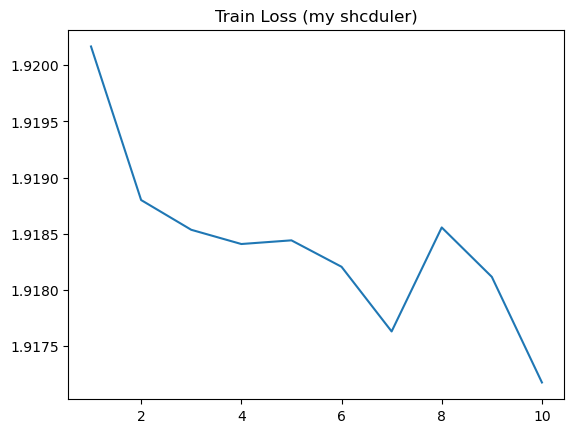

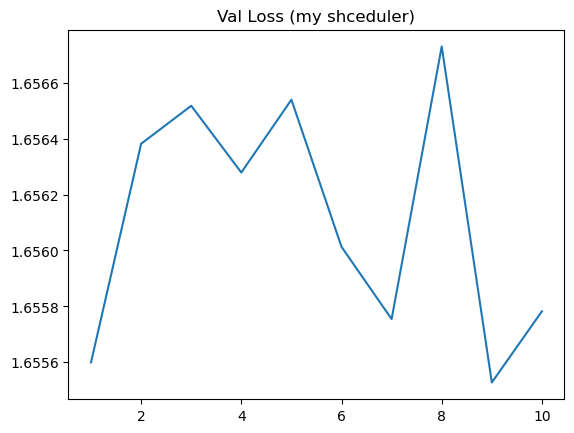

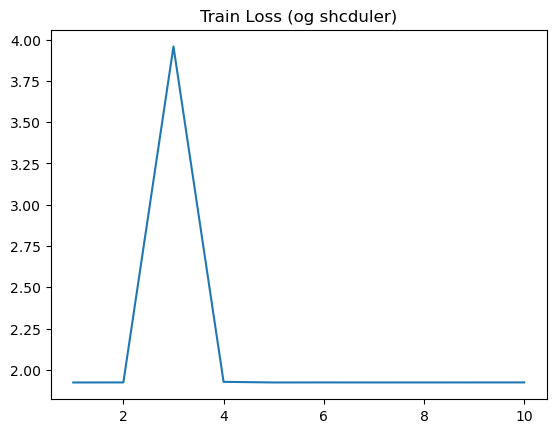

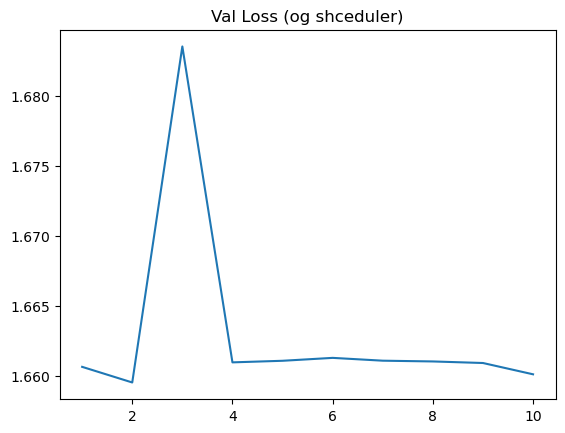

In [339]:
# Plot here
sns.lineplot(x=[i for i in range(1,11)], y= my_train_losses).set_title('Train Loss (my shcduler)')
plt.show()
sns.lineplot(x=[i for i in range(1,11)], y= my_val_losses).set_title('Val Loss (my shceduler)')
plt.show()
sns.lineplot(x=[i for i in range(1,11)], y= my_train_losses2).set_title('Train Loss (og shcduler)')
plt.show()
sns.lineplot(x=[i for i in range(1,11)], y= my_val_losses2).set_title('Val Loss (og shceduler)')
plt.show()

In [236]:
# Evaluate
print('Dropout my scheduler')
print('evaluate training', evaluate(train_loader, my_model).item())
print('evaluate validation', evaluate(val_loader, my_model).item())

Dropout my scheduler


  0%|          | 0/1121 [00:00<?, ?it/s]

evaluate training 1.916887640953064


  0%|          | 0/454 [00:00<?, ?it/s]

evaluate validation 1.6557823419570923


In [240]:
print('Dropout og scheduler')
print('evaluate training', evaluate(train_loader, my_model2).item())
print('evaluate validation', evaluate(val_loader, my_model2).item())

Dropout og scheduler


  0%|          | 0/1121 [00:00<?, ?it/s]

evaluate training 1.924614667892456


  0%|          | 0/454 [00:00<?, ?it/s]

evaluate validation 1.6601234674453735


In [241]:
print('FF model same scheduler')
print('evaluate training', evaluate(train_loader, model_ff).item())
print('evaluate validation', evaluate(val_loader, model_ff).item())

FF model same scheduler


  0%|          | 0/1121 [00:00<?, ?it/s]

evaluate training 1.9236546754837036


  0%|          | 0/454 [00:00<?, ?it/s]

evaluate validation 1.6613097190856934


In [237]:
print('FF model with my scheduler')
print('evaluate training', evaluate(train_loader, model_ff2).item())
print('evaluate validation', evaluate(val_loader, model_ff2).item())

FF model with my scheduler


  0%|          | 0/1121 [00:00<?, ?it/s]

evaluate training 1.9168813228607178


  0%|          | 0/454 [00:00<?, ?it/s]

evaluate validation 1.655452013015747


# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [242]:
################################################################################
# TODO#14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


In [311]:
def preprocess_for_cnn(x_train, y_train, x_val, y_val):
    x_train_cnn = x_train.reshape((-1, 3, 5 , 5))
    y_train_cnn = y_train.reshape((-1, 1))
    x_val_cnn = x_val.reshape((-1, 3, 5,5))
    y_val_cnn = y_val.reshape((-1, 1))
    x_test_cnn = x_test.reshape((-1, 3, 5, 5))
    y_test_cnn = y_test.reshape((-1, 1))

    return x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn

x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn = preprocess_for_cnn(x_train, y_train, x_val, y_val)
print(x_train_cnn.shape, y_train_cnn.shape)
print(x_val_cnn.shape, y_val_cnn.shape)
print(x_test_cnn.shape, y_test_cnn.shape)

(1147740, 3, 5, 5) (1147740, 1)
(464195, 3, 5, 5) (464195, 1)
(558575, 3, 5, 5) (558575, 1)


In [312]:
x_train_cnn.mean(0).shape

(3, 5, 5)

In [313]:
import torchvision.transforms as T
def cnn_normalizer(X):
    mean, std = X.mean(0), X.std(0)
    norm = T.Normalize(mean=mean, std=std)
    return norm

In [314]:
class RainfallDatasetCNN(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer(torch.Tensor(x)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [315]:
cnn_normalizer = cnn_normalizer(x_train_cnn) # normalize everything based on x_train
cnn_train_dataset = RainfallDatasetCNN(x_train_cnn, y_train_cnn, cnn_normalizer)
cnn_val_dataset = RainfallDatasetCNN(x_val_cnn, y_val_cnn, cnn_normalizer)
cnn_test_dataset = RainfallDatasetCNN(x_test_cnn, y_test_cnn, cnn_normalizer)

(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [316]:
cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=2024, shuffle=True, pin_memory=True)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=2024, shuffle=True, pin_memory=True)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=1024, shuffle=True, pin_memory=True)

In [541]:
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=200, kernel_size=3)
        self.ff1 = nn.Linear(1800, 200)
        self.ff2 = nn.Linear(200, 200)
        self.ff3 = nn.Linear(200, 1)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        y = F.relu(self.ff3(x))
        return y.reshape(-1, 1)

In [542]:
cnn_model = MyCNN()
summary(cnn_model, input_size=(1024, 3, 5,5))

Layer (type:depth-idx)                   Output Shape              Param #
MyCNN                                    [1024, 1]                 --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
Total mult-adds (M): 461.83
Input size (MB): 0.31
Forward/backward pass size (MB): 18.03
Params size (MB): 1.62
Estimated Total Size (MB): 19.96

In [393]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
cnn_config = {
    'architechture': 'dropout',
    'lr': 0.01,
    'hidden_size': 200,
    'epochs':10
}
cnn_model = MyCNN()
cnn_model = cnn_model.to(device)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr = my_config['lr'])
cnn_scheduler = MyScheduler(cnn_optimizer)
#Training
cnn_train_losses = []
cnn_val_losses = []
cnn_learning_rates = []

# Strat wandb run
wandb.init(
    project='precipitaion-nowcasting',
    config= cnn_config
)

#Log parameters and gradients
wandb.watch(cnn_model, log='all')

for epoch in range(cnn_config['epochs']):
    #Training
    train_loss = []
    current_lr = cnn_optimizer.param_groups[0]['lr']
    cnn_learning_rates.append(current_lr)

    #Flag model as training
    cnn_model.train()

    print(f'Training epoch {epoch + 1}...')
    print(f'Current LR: {current_lr}')

    for i, (inputs, y_true) in enumerate(tqdm(cnn_train_loader)):
        #tranfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        #Reset gradient
        cnn_optimizer.zero_grad()

        #Predict
        y_pred = cnn_model(inputs)

        #Calculate loss
        loss = loss_fn(y_pred, y_true)

        #Calculate gradient
        loss.backward()

        #Update parameters
        cnn_optimizer.step()

        #Log
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    cnn_train_losses.append(avg_train_loss)

    print(f'Epoch {epoch + 1} train loss: {avg_train_loss:.4f}')

    #Validation
    cnn_model.eval()
    with torch.no_grad():
        print(f'Validating epoch {epoch + 1}')
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(cnn_val_loader)):
            #tranfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            #Predict
            y_pred = cnn_model(inputs)

            #Calculate loss
            loss = loss_fn(y_pred, y_true)

            #log
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        cnn_val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch + 1} validation loss: {avg_val_loss:.4f}')

        #LR scheduler
        cnn_scheduler.step(epoch)

        #Save Chechpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(cnn_val_losses[:-1])
        if avg_val_loss < best_val_loss:
            state = {
                'epoch': epoch,
                'model': cnn_model.state_dict(),
                'optimizer': cnn_optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'validation_loss': avg_val_loss,
                'best_val_loss': best_val_loss
            }
            print(f'Saving new best model...')
            torch.save(state, 'cnn_model.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr
    })

wandb.unwatch()
wandb.finish()
print('Finished Training')

start training conv2d


Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9441
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 validation loss: 1.6836
Saving new best model...
Training epoch 2...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9440
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 validation loss: 1.6723
Saving new best model...
Training epoch 3...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9440
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 validation loss: 1.6750
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9440
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 validation loss: 1.6727
Training epoch 5...
Current LR: 0.0008333333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9439
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 validation loss: 1.6794
Training epoch 6...
Current LR: 0.0006666666666666668


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9456
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 validation loss: 1.6722
Saving new best model...
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9443
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 validation loss: 1.6731
Training epoch 8...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9438
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 validation loss: 1.6721
Saving new best model...
Training epoch 9...
Current LR: 0.00055


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9438
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 validation loss: 1.6830
Training epoch 10...
Current LR: 0.00010000000000000005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9443
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 validation loss: 1.6726


lr,▁▃▆█▇▅▄█▄▁
train_loss,▂▂▂▂▂█▃▁▁▃
val_loss,█▁▃▁▅▁▂▁█▁
lr,0.0001
train_loss,1.9443
val_loss,1.67261


Finished Training


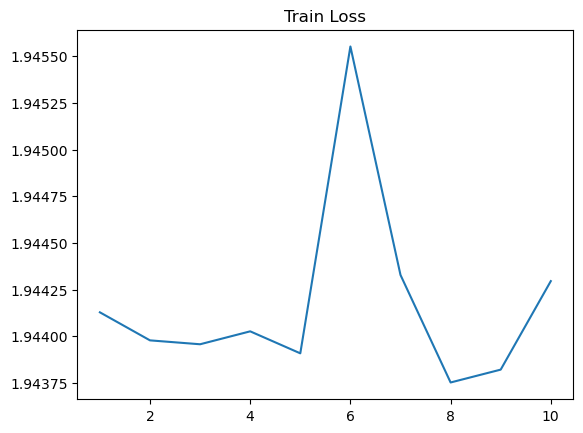

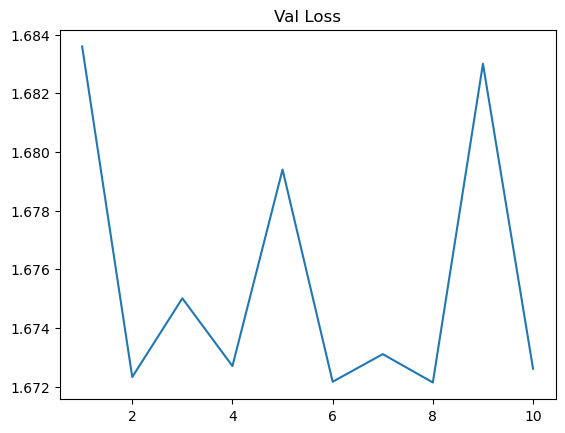

In [394]:
# Plot losses
sns.lineplot(x= [i for i in range(1,11)], y = cnn_train_losses).set_title('Train Loss')
plt.show()
sns.lineplot(x= [i for i in range(1,11)], y = cnn_val_losses).set_title('Val Loss')
plt.show()

In [395]:
# Evaluate
print('CNN Model')
print('training', evaluate(model=cnn_model, data_loader=cnn_train_loader).item())
print('validation', evaluate(model=cnn_model, data_loader=cnn_val_loader).item())

CNN Model


  0%|          | 0/1121 [00:00<?, ?it/s]

training 1.9438626766204834


  0%|          | 0/454 [00:00<?, ?it/s]

validation 1.6746329069137573


# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [396]:
################################################################################
# TODO#17:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


In [499]:
def preprocess_for_gru(x_train, y_train, x_val, y_val):
    x_train_gru = x_train.reshape((-1, 5, 5*5*3))
    y_train_gru = y_train.reshape((-1, 5,1))
    x_val_gru = x_val.reshape((-1, 5, 5*5*3))
    y_val_gru = y_val.reshape((-1, 5,1))
    x_test_gru = x_test.reshape((-1, 5, 5*5*3))
    y_test_gru = y_test.reshape((-1, 5,1))

    return x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru

x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru = preprocess_for_gru(x_train, y_train, x_val, y_val)
print(x_train_gru.shape, y_train_gru.shape)
print(x_val_gru.shape, y_val_gru.shape)
print(x_test_gru.shape, y_test_gru.shape)

(229548, 5, 75) (229548, 5, 1)
(92839, 5, 75) (92839, 5, 1)
(111715, 5, 75) (111715, 5, 1)


In [500]:
class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [501]:
gru_train_dataset = RainfallDatasetGRU(x_train_gru, y_train_gru)
gru_val_dataset = RainfallDatasetGRU(x_val_gru, y_val_gru)
gru_test_dataset = RainfallDatasetGRU(x_test_gru, y_test_gru)

(229548, 5, 75)
(229548, 5, 1)
(92839, 5, 75)
(92839, 5, 1)
(111715, 5, 75)
(111715, 5, 1)


In [600]:
gru_train_loader = DataLoader(gru_train_dataset, batch_size=2048, shuffle=True, pin_memory=True)
gru_val_loader = DataLoader(gru_val_dataset, batch_size=2048, shuffle=True, pin_memory=True)
gru_test_loader = DataLoader(gru_test_dataset, batch_size=2048, shuffle=True, pin_memory=True)

In [544]:
a,b = next(iter(gru_train_loader))
a.shape, b.shape

(torch.Size([2048, 5, 75]), torch.Size([2048, 5, 1]))

In [601]:
################################################################################
# TODO#18                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class MyGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=75,hidden_size=200,batch_first = True,num_layers = 5)
        self.norm = nn.GroupNorm(5,5)
        self.hn = torch.randn(5,2048,200).to(device)
        self.ff0 = nn.Linear(75,200)
        self.ff1 = nn.Linear(200,200)
        self.ff2 = nn.Linear(200,1)
    def forward(self, x):
        if(x.shape[0] == 2048):
            x, hn = self.gru(x,self.hn)
            x = F.relu(self.norm(x))
        else:
            x = F.relu(self.ff0(x))
        x = F.relu(self.ff1(x))
        y = F.relu(self.ff2(x))
        return y

In [602]:
gru_model = MyGRU()
summary(gru_model, input_size=(2048, 5, 75))

Layer (type:depth-idx)                   Output Shape              Param #
MyGRU                                    [2048, 5, 1]              15,200
├─GRU: 1-1                               [2048, 5, 200]            1,131,000
├─GroupNorm: 1-2                         [2048, 5, 200]            10
├─Linear: 1-3                            [2048, 5, 200]            40,200
├─Linear: 1-4                            [2048, 5, 1]              201
Total params: 1,186,611
Trainable params: 1,186,611
Non-trainable params: 0
Total mult-adds (G): 11.66
Input size (MB): 3.07
Forward/backward pass size (MB): 49.23
Params size (MB): 4.69
Estimated Total Size (MB): 56.99

In [619]:
################################################################################
# TODO#19                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
gru_config = {
    'architecture': 'gru',
    'lr': 0.01245,
    'hidden_size': 200,
    'scheduler_factor': 0.1,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 256
}
gru_model = MyGRU()
gru_model = gru_model.to(device)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr = gru_config['lr'])
gru_scheduler =  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85, cycle_momentum=False)
#Training
gru_train_losses = []
gru_val_losses = []
gru_learning_rates = []

# Strat wandb run
wandb.init(
    project='precipitaion-nowcasting',
    config= gru_config
)

#Log parameters and gradients
wandb.watch(gru_model, log='all')

for epoch in range(gru_config['epochs']):
    #Training
    train_loss = []
    current_lr = gru_optimizer.param_groups[0]['lr']
    gru_learning_rates.append(current_lr)

    #Flag model as training
    gru_model.train()

    print(f'Training epoch {epoch + 1}...')
    print(f'Current LR: {current_lr}')

    for i, (inputs, y_true) in enumerate(tqdm(gru_train_loader)):
        #tranfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)
        # print(inputs.shape)

        #Reset gradient
        gru_optimizer.zero_grad()

        #Predict
        y_pred = gru_model(inputs)

        #Calculate loss
        all_linear1_params = torch.cat([x.view(-1) for x in gru_model.ff1.parameters()])
        all_linear2_params = torch.cat([x.view(-1) for x in gru_model.ff2.parameters()])
        l1_regularization1 = 0.03 * torch.norm(all_linear1_params, 1)
        l1_regularization2 = 0.03 * torch.norm(all_linear2_params, 1)
        loss = loss_fn(y_pred, y_true)
        loss2 = loss + l1_regularization1 + l1_regularization2

        #Calculate gradient
        loss2.backward()

        #Update parameters
        gru_optimizer.step()

        #Log
        train_loss.append(loss2)

    avg_train_loss = torch.stack(train_loss).mean().item()
    gru_train_losses.append(avg_train_loss)

    print(f'Epoch {epoch + 1} train loss: {avg_train_loss:.4f}')

    #Validation
    gru_model.eval()
    with torch.no_grad():
        print(f'Validating epoch {epoch + 1}')
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(gru_val_loader)):
            #tranfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            #Predict
            y_pred = gru_model(inputs)

            #Calculate loss
            loss = loss_fn(y_pred, y_true)

            #log
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        gru_val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch + 1} validation loss: {avg_val_loss:.4f}')

        #LR scheduler
        gru_scheduler.step()

        #Save Chechpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(gru_val_losses[:-1])
        if avg_val_loss < best_val_loss:
            state = {
                'epoch': epoch,
                'model': gru_model.state_dict(),
                'optimizer': gru_optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'validation_loss': avg_val_loss,
                'best_val_loss': best_val_loss
            }
            print(f'Saving new best model...')
            torch.save(state, 'gru_model.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr
    })

wandb.unwatch()
wandb.finish()
print('Finished Training')

start training gru


Training epoch 1...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1 train loss: 5.8938
Validating epoch 1


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1 validation loss: 1.7492
Saving new best model...
Training epoch 2...
Current LR: 0.01245


/home/naratip/micromamba/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2 train loss: 3.8067
Validating epoch 2


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2 validation loss: 1.6632
Saving new best model...
Training epoch 3...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3 train loss: 3.7743
Validating epoch 3


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3 validation loss: 104.3284
Training epoch 4...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4 train loss: 3.8301
Validating epoch 4


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4 validation loss: 1.7229
Training epoch 5...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5 train loss: 4.2986
Validating epoch 5


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5 validation loss: 1.6669
Training epoch 6...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6 train loss: 3.7239
Validating epoch 6


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6 validation loss: 1.6570
Saving new best model...
Training epoch 7...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7 train loss: 3.6683
Validating epoch 7


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7 validation loss: 1.6761
Training epoch 8...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8 train loss: 4.4690
Validating epoch 8


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8 validation loss: 1.6645
Training epoch 9...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9 train loss: 3.6763
Validating epoch 9


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9 validation loss: 1.6565
Saving new best model...
Training epoch 10...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10 train loss: 3.6718
Validating epoch 10


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10 validation loss: 2663.8352
Training epoch 11...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11 train loss: 7.7173
Validating epoch 11


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11 validation loss: 1.6752
Training epoch 12...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12 train loss: 33.8650
Validating epoch 12


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12 validation loss: 1.6891
Training epoch 13...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13 train loss: 29.8740
Validating epoch 13


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13 validation loss: 1.6660
Training epoch 14...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14 train loss: 25.4843
Validating epoch 14


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14 validation loss: 1.6647
Training epoch 15...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15 train loss: 22.4049
Validating epoch 15


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15 validation loss: 1.6931
Training epoch 16...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 16 train loss: 19.9704
Validating epoch 16


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16 validation loss: 1.6987
Training epoch 17...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 17 train loss: 18.0718
Validating epoch 17


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17 validation loss: 1.6609
Training epoch 18...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 18 train loss: 16.6177
Validating epoch 18


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18 validation loss: 1.6814
Training epoch 19...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 19 train loss: 15.4330
Validating epoch 19


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19 validation loss: 1.6791
Training epoch 20...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 20 train loss: 14.5088
Validating epoch 20


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20 validation loss: 1.6706
Training epoch 21...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 21 train loss: 13.7443
Validating epoch 21


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 21 validation loss: 1.6800
Training epoch 22...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 22 train loss: 13.1094
Validating epoch 22


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22 validation loss: 1.6760
Training epoch 23...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 23 train loss: 12.6000
Validating epoch 23


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 23 validation loss: 1.6730
Training epoch 24...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 24 train loss: 12.1694
Validating epoch 24


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 24 validation loss: 1.6681
Training epoch 25...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 25 train loss: 11.8105
Validating epoch 25


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 25 validation loss: 1.6711
Training epoch 26...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 26 train loss: 11.5227
Validating epoch 26


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 26 validation loss: 1.6740
Training epoch 27...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 27 train loss: 11.2495
Validating epoch 27


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 27 validation loss: 1.6766
Training epoch 28...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 28 train loss: 11.0333
Validating epoch 28


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 28 validation loss: 1.6704
Training epoch 29...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 29 train loss: 10.8272
Validating epoch 29


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 29 validation loss: 1.6629
Training epoch 30...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 30 train loss: 10.6705
Validating epoch 30


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 30 validation loss: 1.6846
Training epoch 31...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 31 train loss: 10.4857
Validating epoch 31


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 31 validation loss: 1.6671
Training epoch 32...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 32 train loss: 10.3715
Validating epoch 32


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 32 validation loss: 1.6668
Training epoch 33...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 33 train loss: 10.2158
Validating epoch 33


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 33 validation loss: 1.6806
Training epoch 34...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 34 train loss: 10.1091
Validating epoch 34


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 34 validation loss: 1.6877
Training epoch 35...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 35 train loss: 9.9673
Validating epoch 35


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 35 validation loss: 1.6825
Training epoch 36...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 36 train loss: 9.8659
Validating epoch 36


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 36 validation loss: 1.6614
Training epoch 37...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 37 train loss: 9.7832
Validating epoch 37


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 37 validation loss: 1.6783
Training epoch 38...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 38 train loss: 9.6294
Validating epoch 38


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 38 validation loss: 1.6764
Training epoch 39...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 39 train loss: 9.5419
Validating epoch 39


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 39 validation loss: 1.6599
Training epoch 40...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 40 train loss: 9.4483
Validating epoch 40


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 40 validation loss: 1.6923
Training epoch 41...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 41 train loss: 9.3330
Validating epoch 41


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 41 validation loss: 1.6632
Training epoch 42...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 42 train loss: 9.2129
Validating epoch 42


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 42 validation loss: 1.6707
Training epoch 43...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 43 train loss: 9.1067
Validating epoch 43


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 43 validation loss: 1.6923
Training epoch 44...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 44 train loss: 9.0348
Validating epoch 44


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 44 validation loss: 1.6560
Saving new best model...
Training epoch 45...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 45 train loss: 8.8782
Validating epoch 45


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 45 validation loss: 1.6782
Training epoch 46...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 46 train loss: 8.7981
Validating epoch 46


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 46 validation loss: 1.6780
Training epoch 47...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 47 train loss: 8.6584
Validating epoch 47


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 47 validation loss: 1.6691
Training epoch 48...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 48 train loss: 8.5298
Validating epoch 48


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 48 validation loss: 1.6932
Training epoch 49...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 49 train loss: 8.4023
Validating epoch 49


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 49 validation loss: 1.6895
Training epoch 50...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 50 train loss: 8.2748
Validating epoch 50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 50 validation loss: 1.6750
Training epoch 51...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 51 train loss: 8.1499
Validating epoch 51


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 51 validation loss: 1.6622
Training epoch 52...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 52 train loss: 8.0151
Validating epoch 52


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 52 validation loss: 1.6580
Training epoch 53...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 53 train loss: 7.8635
Validating epoch 53


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 53 validation loss: 1.6628
Training epoch 54...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 54 train loss: 7.7316
Validating epoch 54


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 54 validation loss: 1.6628
Training epoch 55...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 55 train loss: 7.6020
Validating epoch 55


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 55 validation loss: 1.6685
Training epoch 56...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 56 train loss: 7.4653
Validating epoch 56


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 56 validation loss: 259.6118
Training epoch 57...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 57 train loss: 7.5478
Validating epoch 57


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 57 validation loss: 1.6797
Training epoch 58...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 58 train loss: 7.2681
Validating epoch 58


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 58 validation loss: 1.6652
Training epoch 59...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 59 train loss: 7.0405
Validating epoch 59


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 59 validation loss: 1.6629
Training epoch 60...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 60 train loss: 7.2030
Validating epoch 60


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 60 validation loss: 1.6802
Training epoch 61...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 61 train loss: 6.7664
Validating epoch 61


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 61 validation loss: 1.6737
Training epoch 62...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 62 train loss: 6.6115
Validating epoch 62


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 62 validation loss: 1.6718
Training epoch 63...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 63 train loss: 6.4932
Validating epoch 63


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 63 validation loss: 728.4777
Training epoch 64...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 64 train loss: 6.6577
Validating epoch 64


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 64 validation loss: 1.6578
Training epoch 65...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 65 train loss: 6.7196
Validating epoch 65


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 65 validation loss: 1.6496
Saving new best model...
Training epoch 66...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 66 train loss: 6.2229
Validating epoch 66


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 66 validation loss: 1.6608
Training epoch 67...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 67 train loss: 5.9679
Validating epoch 67


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 67 validation loss: 1.6771
Training epoch 68...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 68 train loss: 6.0494
Validating epoch 68


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 68 validation loss: 1.6543
Training epoch 69...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 69 train loss: 5.6253
Validating epoch 69


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 69 validation loss: 1.6501
Training epoch 70...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 70 train loss: 5.5382
Validating epoch 70


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 70 validation loss: 176.2889
Training epoch 71...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 71 train loss: 5.4810
Validating epoch 71


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 71 validation loss: 1.7286
Training epoch 72...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 72 train loss: 5.2579
Validating epoch 72


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 72 validation loss: 1.6729
Training epoch 73...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 73 train loss: 5.7665
Validating epoch 73


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 73 validation loss: 1.6555
Training epoch 74...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 74 train loss: 5.0784
Validating epoch 74


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 74 validation loss: 1.6568
Training epoch 75...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 75 train loss: 4.8797
Validating epoch 75


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 75 validation loss: 1.6721
Training epoch 76...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 76 train loss: 4.7495
Validating epoch 76


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 76 validation loss: 1.6835
Training epoch 77...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 77 train loss: 4.6693
Validating epoch 77


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 77 validation loss: 2.9633
Training epoch 78...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 78 train loss: 4.5460
Validating epoch 78


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 78 validation loss: 1.6848
Training epoch 79...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 79 train loss: 4.5631
Validating epoch 79


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 79 validation loss: 1.6945
Training epoch 80...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 80 train loss: 4.3775
Validating epoch 80


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 80 validation loss: 1.6690
Training epoch 81...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 81 train loss: 4.4864
Validating epoch 81


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 81 validation loss: 1.6733
Training epoch 82...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 82 train loss: 4.1904
Validating epoch 82


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 82 validation loss: 1.6555
Training epoch 83...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 83 train loss: 4.2185
Validating epoch 83


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 83 validation loss: 1.6603
Training epoch 84...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 84 train loss: 4.0491
Validating epoch 84


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 84 validation loss: 33.5397
Training epoch 85...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 85 train loss: 4.0808
Validating epoch 85


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 85 validation loss: 1.6644
Training epoch 86...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 86 train loss: 4.2715
Validating epoch 86


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 86 validation loss: 1.6580
Training epoch 87...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 87 train loss: 3.9018
Validating epoch 87


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 87 validation loss: 1.6520
Training epoch 88...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 88 train loss: 3.9812
Validating epoch 88


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 88 validation loss: 1.6935
Training epoch 89...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 89 train loss: 3.9125
Validating epoch 89


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 89 validation loss: 10.1942
Training epoch 90...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 90 train loss: 3.8145
Validating epoch 90


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 90 validation loss: 117.6637
Training epoch 91...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 91 train loss: 3.8736
Validating epoch 91


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 91 validation loss: 1.6542
Training epoch 92...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 92 train loss: 5.8451
Validating epoch 92


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 92 validation loss: 1.6780
Training epoch 93...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 93 train loss: 4.3227
Validating epoch 93


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 93 validation loss: 1.6531
Training epoch 94...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 94 train loss: 4.0365
Validating epoch 94


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 94 validation loss: 1.6736
Training epoch 95...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 95 train loss: 3.8971
Validating epoch 95


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 95 validation loss: 1.6658
Training epoch 96...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 96 train loss: 3.8194
Validating epoch 96


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 96 validation loss: 1.6702
Training epoch 97...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 97 train loss: 3.7687
Validating epoch 97


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 97 validation loss: 1.6671
Training epoch 98...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 98 train loss: 3.7334
Validating epoch 98


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 98 validation loss: 1.6585
Training epoch 99...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 99 train loss: 3.8419
Validating epoch 99


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 99 validation loss: 1.6520
Training epoch 100...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 100 train loss: 3.6838
Validating epoch 100


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 100 validation loss: 1.6678
Training epoch 101...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 101 train loss: 4.1154
Validating epoch 101


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 101 validation loss: 1.6626
Training epoch 102...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 102 train loss: 3.6985
Validating epoch 102


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 102 validation loss: 1.6489
Saving new best model...
Training epoch 103...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 103 train loss: 3.6539
Validating epoch 103


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 103 validation loss: 1.6501
Training epoch 104...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 104 train loss: 3.6394
Validating epoch 104


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 104 validation loss: 1.6701
Training epoch 105...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 105 train loss: 3.8422
Validating epoch 105


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 105 validation loss: 1.6454
Saving new best model...
Training epoch 106...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 106 train loss: 4.5346
Validating epoch 106


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 106 validation loss: 1.6768
Training epoch 107...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 107 train loss: 3.8876
Validating epoch 107


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 107 validation loss: 1.6655
Training epoch 108...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 108 train loss: 3.8007
Validating epoch 108


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 108 validation loss: 1.6672
Training epoch 109...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 109 train loss: 6.2939
Validating epoch 109


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 109 validation loss: 1.6656
Training epoch 110...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 110 train loss: 4.3540
Validating epoch 110


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 110 validation loss: 1.6621
Training epoch 111...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 111 train loss: 4.0968
Validating epoch 111


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 111 validation loss: 1.6975
Training epoch 112...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 112 train loss: 3.9448
Validating epoch 112


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 112 validation loss: 1.6706
Training epoch 113...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 113 train loss: 3.8508
Validating epoch 113


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 113 validation loss: 1.6615
Training epoch 114...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 114 train loss: 3.8007
Validating epoch 114


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 114 validation loss: 1.6596
Training epoch 115...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 115 train loss: 3.7464
Validating epoch 115


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 115 validation loss: 1.6628
Training epoch 116...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 116 train loss: 3.7188
Validating epoch 116


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 116 validation loss: 1.6544
Training epoch 117...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 117 train loss: 3.7119
Validating epoch 117


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 117 validation loss: 1.6750
Training epoch 118...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 118 train loss: 3.6902
Validating epoch 118


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 118 validation loss: 1.6626
Training epoch 119...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 119 train loss: 3.7034
Validating epoch 119


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 119 validation loss: 1.6572
Training epoch 120...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 120 train loss: 3.6789
Validating epoch 120


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 120 validation loss: 1.6508
Training epoch 121...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 121 train loss: 3.6999
Validating epoch 121


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 121 validation loss: 1.6598
Training epoch 122...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 122 train loss: 3.6759
Validating epoch 122


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 122 validation loss: 1.6700
Training epoch 123...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 123 train loss: 3.7046
Validating epoch 123


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 123 validation loss: 1.6564
Training epoch 124...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 124 train loss: 3.6579
Validating epoch 124


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 124 validation loss: 1.6714
Training epoch 125...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 125 train loss: 3.6651
Validating epoch 125


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 125 validation loss: 1.6738
Training epoch 126...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 126 train loss: 3.6641
Validating epoch 126


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 126 validation loss: 1.6704
Training epoch 127...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 127 train loss: 3.6523
Validating epoch 127


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 127 validation loss: 1.6479
Training epoch 128...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 128 train loss: 6.8166
Validating epoch 128


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 128 validation loss: 1.6596
Training epoch 129...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 129 train loss: 4.3697
Validating epoch 129


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 129 validation loss: 1.6760
Training epoch 130...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 130 train loss: 3.9750
Validating epoch 130


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 130 validation loss: 1.6582
Training epoch 131...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 131 train loss: 3.8383
Validating epoch 131


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 131 validation loss: 1.6665
Training epoch 132...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 132 train loss: 3.7481
Validating epoch 132


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 132 validation loss: 1.6539
Training epoch 133...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 133 train loss: 3.7149
Validating epoch 133


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 133 validation loss: 1.6588
Training epoch 134...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 134 train loss: 3.6642
Validating epoch 134


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 134 validation loss: 1.6598
Training epoch 135...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 135 train loss: 3.6431
Validating epoch 135


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 135 validation loss: 1.6528
Training epoch 136...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 136 train loss: 3.6306
Validating epoch 136


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 136 validation loss: 1.6524
Training epoch 137...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 137 train loss: 3.6350
Validating epoch 137


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 137 validation loss: 1.6536
Training epoch 138...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 138 train loss: 3.6335
Validating epoch 138


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 138 validation loss: 1.6606
Training epoch 139...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 139 train loss: 3.6254
Validating epoch 139


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 139 validation loss: 1.6645
Training epoch 140...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 140 train loss: 3.6263
Validating epoch 140


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 140 validation loss: 124.2152
Training epoch 141...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 141 train loss: 3.8712
Validating epoch 141


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 141 validation loss: 1959.8856
Training epoch 142...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 142 train loss: 7.1577
Validating epoch 142


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 142 validation loss: 1.6521
Training epoch 143...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 143 train loss: 17.9066
Validating epoch 143


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 143 validation loss: 1.6641
Training epoch 144...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 144 train loss: 15.5992
Validating epoch 144


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 144 validation loss: 1.6651
Training epoch 145...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 145 train loss: 13.8282
Validating epoch 145


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 145 validation loss: 1.6627
Training epoch 146...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 146 train loss: 12.6870
Validating epoch 146


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 146 validation loss: 1.6743
Training epoch 147...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 147 train loss: 11.8076
Validating epoch 147


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 147 validation loss: 1.6684
Training epoch 148...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 148 train loss: 11.1499
Validating epoch 148


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 148 validation loss: 1.7316
Training epoch 149...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 149 train loss: 10.5436
Validating epoch 149


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 149 validation loss: 1.6581
Training epoch 150...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 150 train loss: 10.0300
Validating epoch 150


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 150 validation loss: 1.6566
Training epoch 151...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 151 train loss: 9.5808
Validating epoch 151


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 151 validation loss: 1.7176
Training epoch 152...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 152 train loss: 9.1798
Validating epoch 152


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 152 validation loss: 1.6750
Training epoch 153...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 153 train loss: 8.8352
Validating epoch 153


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 153 validation loss: 1.6599
Training epoch 154...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 154 train loss: 8.5360
Validating epoch 154


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 154 validation loss: 1.6616
Training epoch 155...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 155 train loss: 8.2928
Validating epoch 155


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 155 validation loss: 1.6798
Training epoch 156...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 156 train loss: 8.0681
Validating epoch 156


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 156 validation loss: 1.6891
Training epoch 157...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 157 train loss: 7.8718
Validating epoch 157


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 157 validation loss: 1.6834
Training epoch 158...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 158 train loss: 7.6906
Validating epoch 158


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 158 validation loss: 1.6757
Training epoch 159...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 159 train loss: 7.5217
Validating epoch 159


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 159 validation loss: 1.6684
Training epoch 160...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 160 train loss: 7.3684
Validating epoch 160


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 160 validation loss: 1.6606
Training epoch 161...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 161 train loss: 7.2387
Validating epoch 161


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 161 validation loss: 1.6757
Training epoch 162...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 162 train loss: 7.1607
Validating epoch 162


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 162 validation loss: 1.6903
Training epoch 163...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 163 train loss: 7.0126
Validating epoch 163


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 163 validation loss: 1.7059
Training epoch 164...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 164 train loss: 6.9232
Validating epoch 164


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 164 validation loss: 1.6855
Training epoch 165...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 165 train loss: 6.8085
Validating epoch 165


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 165 validation loss: 1.6730
Training epoch 166...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 166 train loss: 6.7200
Validating epoch 166


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 166 validation loss: 1.6635
Training epoch 167...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 167 train loss: 6.6274
Validating epoch 167


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 167 validation loss: 1.6706
Training epoch 168...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 168 train loss: 6.5302
Validating epoch 168


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 168 validation loss: 1.6672
Training epoch 169...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 169 train loss: 6.4454
Validating epoch 169


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 169 validation loss: 1.6609
Training epoch 170...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 170 train loss: 6.3723
Validating epoch 170


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 170 validation loss: 1.6545
Training epoch 171...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 171 train loss: 6.2965
Validating epoch 171


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 171 validation loss: 1.6800
Training epoch 172...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 172 train loss: 6.2227
Validating epoch 172


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 172 validation loss: 1.6709
Training epoch 173...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 173 train loss: 6.1825
Validating epoch 173


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 173 validation loss: 1.6718
Training epoch 174...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 174 train loss: 6.0886
Validating epoch 174


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 174 validation loss: 1.6632
Training epoch 175...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 175 train loss: 6.0088
Validating epoch 175


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 175 validation loss: 1.6621
Training epoch 176...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 176 train loss: 5.9610
Validating epoch 176


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 176 validation loss: 1.6792
Training epoch 177...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 177 train loss: 5.9085
Validating epoch 177


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 177 validation loss: 1.6822
Training epoch 178...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 178 train loss: 5.8426
Validating epoch 178


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 178 validation loss: 1.6880
Training epoch 179...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 179 train loss: 5.7725
Validating epoch 179


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 179 validation loss: 1.6791
Training epoch 180...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 180 train loss: 5.7230
Validating epoch 180


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 180 validation loss: 1.6619
Training epoch 181...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 181 train loss: 5.6685
Validating epoch 181


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 181 validation loss: 1.6826
Training epoch 182...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 182 train loss: 5.6158
Validating epoch 182


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 182 validation loss: 1.6715
Training epoch 183...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 183 train loss: 5.5680
Validating epoch 183


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 183 validation loss: 1.6703
Training epoch 184...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 184 train loss: 5.5393
Validating epoch 184


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 184 validation loss: 1.6750
Training epoch 185...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 185 train loss: 5.4966
Validating epoch 185


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 185 validation loss: 1.6561
Training epoch 186...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 186 train loss: 5.4245
Validating epoch 186


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 186 validation loss: 1.6517
Training epoch 187...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 187 train loss: 5.3897
Validating epoch 187


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 187 validation loss: 1.6662
Training epoch 188...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 188 train loss: 5.3397
Validating epoch 188


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 188 validation loss: 1.6553
Training epoch 189...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 189 train loss: 5.2709
Validating epoch 189


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 189 validation loss: 1.6570
Training epoch 190...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 190 train loss: 5.2460
Validating epoch 190


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 190 validation loss: 1.6655
Training epoch 191...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 191 train loss: 5.2086
Validating epoch 191


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 191 validation loss: 1.6650
Training epoch 192...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 192 train loss: 5.1388
Validating epoch 192


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 192 validation loss: 1.6890
Training epoch 193...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 193 train loss: 5.1117
Validating epoch 193


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 193 validation loss: 1.6748
Training epoch 194...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 194 train loss: 5.0576
Validating epoch 194


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 194 validation loss: 1.6575
Training epoch 195...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 195 train loss: 5.0278
Validating epoch 195


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 195 validation loss: 1.6448
Saving new best model...
Training epoch 196...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 196 train loss: 5.6950
Validating epoch 196


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 196 validation loss: 1.6747
Training epoch 197...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 197 train loss: 5.0938
Validating epoch 197


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 197 validation loss: 1.6775
Training epoch 198...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 198 train loss: 4.9825
Validating epoch 198


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 198 validation loss: 1.6907
Training epoch 199...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 199 train loss: 4.9856
Validating epoch 199


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 199 validation loss: 1.6556
Training epoch 200...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 200 train loss: 4.8979
Validating epoch 200


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 200 validation loss: 1.6708
Training epoch 201...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 201 train loss: 4.8572
Validating epoch 201


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 201 validation loss: 1.6565
Training epoch 202...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 202 train loss: 4.8276
Validating epoch 202


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 202 validation loss: 1.6508
Training epoch 203...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 203 train loss: 4.7932
Validating epoch 203


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 203 validation loss: 1.6516
Training epoch 204...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 204 train loss: 4.7368
Validating epoch 204


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 204 validation loss: 1.6495
Training epoch 205...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 205 train loss: 4.7224
Validating epoch 205


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 205 validation loss: 1.6506
Training epoch 206...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 206 train loss: 4.6812
Validating epoch 206


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 206 validation loss: 1.6613
Training epoch 207...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 207 train loss: 4.6341
Validating epoch 207


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 207 validation loss: 1.6572
Training epoch 208...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 208 train loss: 4.6580
Validating epoch 208


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 208 validation loss: 1.6519
Training epoch 209...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 209 train loss: 4.5669
Validating epoch 209


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 209 validation loss: 1.6553
Training epoch 210...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 210 train loss: 4.5389
Validating epoch 210


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 210 validation loss: 1.6732
Training epoch 211...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 211 train loss: 4.5210
Validating epoch 211


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 211 validation loss: 1.6736
Training epoch 212...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 212 train loss: 4.4881
Validating epoch 212


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 212 validation loss: 1.6692
Training epoch 213...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 213 train loss: 4.4451
Validating epoch 213


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 213 validation loss: 1.6594
Training epoch 214...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 214 train loss: 4.4062
Validating epoch 214


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 214 validation loss: 1.6709
Training epoch 215...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 215 train loss: 4.3763
Validating epoch 215


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 215 validation loss: 1.6460
Training epoch 216...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 216 train loss: 4.3204
Validating epoch 216


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 216 validation loss: 1.6830
Training epoch 217...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 217 train loss: 4.2904
Validating epoch 217


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 217 validation loss: 1.6519
Training epoch 218...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 218 train loss: 4.3262
Validating epoch 218


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 218 validation loss: 1.6613
Training epoch 219...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 219 train loss: 4.2099
Validating epoch 219


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 219 validation loss: 1.6433
Saving new best model...
Training epoch 220...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 220 train loss: 4.1838
Validating epoch 220


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 220 validation loss: 1.6645
Training epoch 221...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 221 train loss: 4.1411
Validating epoch 221


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 221 validation loss: 1.6538
Training epoch 222...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 222 train loss: 4.1009
Validating epoch 222


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 222 validation loss: 1.6674
Training epoch 223...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 223 train loss: 4.0594
Validating epoch 223


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 223 validation loss: 1.6712
Training epoch 224...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 224 train loss: 4.0222
Validating epoch 224


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 224 validation loss: 1.6542
Training epoch 225...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 225 train loss: 3.9941
Validating epoch 225


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 225 validation loss: 1.6539
Training epoch 226...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 226 train loss: 3.9601
Validating epoch 226


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 226 validation loss: 1.6465
Training epoch 227...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 227 train loss: 3.9318
Validating epoch 227


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 227 validation loss: 1.6794
Training epoch 228...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 228 train loss: 3.9159
Validating epoch 228


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 228 validation loss: 1.6485
Training epoch 229...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 229 train loss: 3.8994
Validating epoch 229


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 229 validation loss: 1.6520
Training epoch 230...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 230 train loss: 3.8558
Validating epoch 230


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 230 validation loss: 1.6767
Training epoch 231...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 231 train loss: 3.8396
Validating epoch 231


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 231 validation loss: 1.6781
Training epoch 232...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 232 train loss: 3.8344
Validating epoch 232


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 232 validation loss: 1.6958
Training epoch 233...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 233 train loss: 3.8093
Validating epoch 233


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 233 validation loss: 1.6776
Training epoch 234...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 234 train loss: 3.7766
Validating epoch 234


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 234 validation loss: 1.6493
Training epoch 235...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 235 train loss: 3.7463
Validating epoch 235


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 235 validation loss: 1.6882
Training epoch 236...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 236 train loss: 3.7359
Validating epoch 236


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 236 validation loss: 1.6788
Training epoch 237...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 237 train loss: 3.7337
Validating epoch 237


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 237 validation loss: 1.6670
Training epoch 238...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 238 train loss: 3.7206
Validating epoch 238


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 238 validation loss: 1.7014
Training epoch 239...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 239 train loss: 3.6888
Validating epoch 239


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 239 validation loss: 1.6863
Training epoch 240...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 240 train loss: 3.6810
Validating epoch 240


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 240 validation loss: 1.6816
Training epoch 241...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 241 train loss: 3.6674
Validating epoch 241


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 241 validation loss: 1.6800
Training epoch 242...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 242 train loss: 3.6661
Validating epoch 242


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 242 validation loss: 1.6523
Training epoch 243...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 243 train loss: 3.6610
Validating epoch 243


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 243 validation loss: 1.6675
Training epoch 244...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 244 train loss: 3.6644
Validating epoch 244


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 244 validation loss: 1.6783
Training epoch 245...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 245 train loss: 3.6393
Validating epoch 245


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 245 validation loss: 1.6934
Training epoch 246...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 246 train loss: 3.6247
Validating epoch 246


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 246 validation loss: 1.6574
Training epoch 247...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 247 train loss: 3.6521
Validating epoch 247


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 247 validation loss: 1.6738
Training epoch 248...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 248 train loss: 3.6193
Validating epoch 248


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 248 validation loss: 1.6566
Training epoch 249...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 249 train loss: 3.6217
Validating epoch 249


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 249 validation loss: 1.6551
Training epoch 250...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 250 train loss: 3.6230
Validating epoch 250


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 250 validation loss: 1.6968
Training epoch 251...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 251 train loss: 3.6150
Validating epoch 251


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 251 validation loss: 1.6775
Training epoch 252...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 252 train loss: 3.6106
Validating epoch 252


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 252 validation loss: 1.6892
Training epoch 253...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 253 train loss: 3.6792
Validating epoch 253


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 253 validation loss: 1.6490
Training epoch 254...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 254 train loss: 3.6213
Validating epoch 254


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 254 validation loss: 617.6451
Training epoch 255...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 255 train loss: 3.9638
Validating epoch 255


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 255 validation loss: 1.6517
Training epoch 256...
Current LR: 0.01245


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 256 train loss: 3.6373
Validating epoch 256


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 256 validation loss: 1.6737


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁█▆▄▄▃▃▃▃▂▂▁▁▂▁▁▁▁▁▁▁▆▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▆▃▃▂▅▅▂▄▂▃▃▅▄▃▃▃▁▃▂▁▃▃▅▄▃▄▃▂▃▁▁▄▃▁▄▄▂▃
lr,0.01245
train_loss,3.63731
val_loss,1.67367


Finished Training


In [616]:
len(gru_train_losses)

400

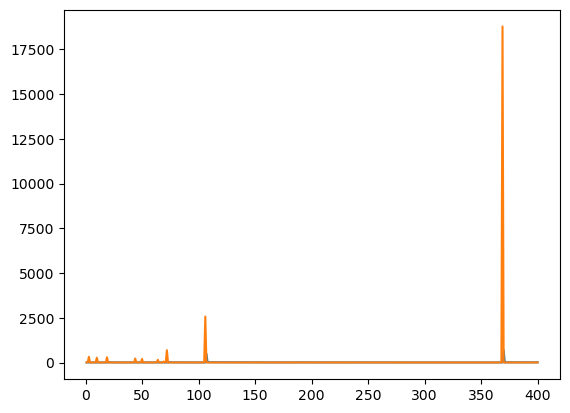

In [617]:
# Plot
sns.lineplot(x = [i for i in range(1, 401)], y = gru_train_losses).set_label('Train loss')
sns.lineplot(x = [i for i in range(1, 401)], y = gru_val_losses).set_label('Val loss')
plt.show()

In [618]:
# Evaluate
print('GRU Model')
print('training', evaluate(model=gru_model, data_loader=gru_train_loader).item())
print('validation', evaluate(model=gru_model, data_loader=gru_val_loader).item())

GRU Model


  0%|          | 0/113 [00:00<?, ?it/s]

training 2.0202243328094482


  0%|          | 0/46 [00:00<?, ?it/s]

validation 1.6726404428482056


# Transformer

Welcome to the beginning of the real world! The aboved models are not usually used in practice due to its limited capability. Transformers are generally used by computer vision, natural language processing, and speech processing (almost every big AI fields).



In our dataloader, we will add the output of this timestep (the number of precipitation) as an auxiliary input to predict the next timestep. Thus, input for the model should be [#batch_size, 5, 76] (5 timesteps and the number 76 comes from (3x5x5)+1) and the output for the model should be [#batch_size, 1] which would be the next timestep we want to predict. Additionally, we will mask the input at the dataloader to the attenttion from observing future values. Suppose that we want to predict timestep 3, we will mask the timestep 3, 4 and 5 in our input by setting it to zeros, and we will predict the timestep 3.

In order to get a score on this TODO, students need to implement a dataloader that mask the input correctly.

In [ ]:
################################################################################
# OT#2:                                                                        #
# Complete the code for preparing data for training Transformer                #
# Transformer's input should has 3 dimensions.                                 #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In this task, we will implement one encoder layer of Transformer and add the linear layer to make a regression prediction. For the simplicity of the model, we will change the multi-head attention to QKV self-attention (single-head). As a result, our model should look like the diagram below. Since the layer self-attention is not availble in torch, students have to implement it themselves. In Add & Norm layer, students have to do the addition before normalizing. In Layer Normalization, we will normalize across both timesteps and features.

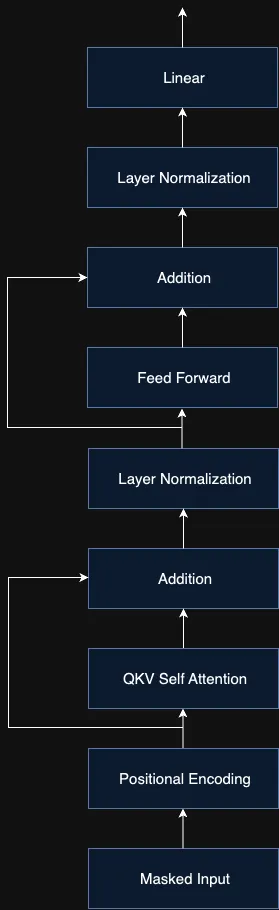

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
TransformerModel                         [1024, 1]                 --
├─PositionalEncoding: 1-1                [1024, 5, 76]             --
│    └─Dropout: 2-1                      [1024, 5, 76]             --
├─SelfAttention: 1-2                     [1024, 5, 76]             --
│    └─Linear: 2-2                       [1024, 5, 76]             5,852
│    └─Linear: 2-3                       [1024, 5, 76]             5,852
│    └─Linear: 2-4                       [1024, 5, 76]             5,852
│    └─Softmax: 2-5                      [1024, 5, 5]              --
├─LayerNorm: 1-3                         [1024, 5, 76]             760
├─Linear: 1-4                            [1024, 5, 76]             5,852
├─LayerNorm: 1-5                         [1024, 5, 76]             760
├─Linear: 1-6                            [1024, 1]                 381
==========================================================================================
Total params: 25,309
Trainable params: 25,309
Non-trainable params: 0
Total mult-adds (M): 25.92
==========================================================================================
Input size (MB): 1.56
Forward/backward pass size (MB): 18.69
Params size (MB): 0.10
Estimated Total Size (MB): 20.34
==========================================================================================
```

In [ ]:
################################################################################
# OT#3                                                                         #
# Write a PyTorch PositionalEncoding model.                                    #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class PositionalEncoding(nn.Module):
  def __init__(self, seq_len, emb_dim, dropout=0.2):
    pass

  def forward(self, x):
    pass

In [ ]:
################################################################################
# OT#4                                                                         #
# Write a PyTorch Transformer model.                                           #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    pass

  def forward(self, x):
    pass

class TransformerModel(nn.Module):
  def __init__(self):
    pass

  def forward(self, x):
    pass


In [ ]:
################################################################################
# OT#5                                                                         #
# Complete the code to train your Transformer model                                    #
################################################################################
print('start training transformer')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

In [ ]:
# Plot

If you implement it correctly, you should evaluate the model in the test dataset and the score should be better than the aboved models.

In [ ]:
# Evaluate

# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [ ]:
# Prep data as you see fit


In [ ]:
################################################################################
# TODO#20                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
################################################################################
# TODO#21                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate best model on validation and test set


In [ ]:
# Also evaluate your fully-connected model and CNN/GRU/Transformer model on the test set.


To get full credit for this part, your best model should be better than the previous models on the **test set**.

### TODO#22

Explain what helped and what did not help here

**Ans:**

# [Optional] Augmentation using data loader

### Optional TODO#6

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [ ]:
# Write Dataset/DataLoader with noise here


In [ ]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate the best model trained with noise on validation and test set
